In [2]:
import pickle
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

1. First, let us get the weights of the model. These data is going to be streamed on one DAC port.

In [3]:
lenet_lin_positive_compress_1 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/converted_positive_data_1.p", "rb"))
lenet_lin_positive_compress_2 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/converted_positive_data_2.p", "rb"))
lenet_lin_positive_compress_3 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/converted_positive_data_3.p", "rb"))
lenet_lin_negative_compress_1 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/converted_negative_data_1.p", "rb"))
lenet_lin_negative_compress_2 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/converted_negative_data_2.p", "rb"))
lenet_lin_negative_compress_3 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/converted_negative_data_3.p", "rb"))

lenet_lin_positive_indices_1 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/positive_indices_1.p", "rb"))
lenet_lin_positive_indices_2 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/positive_indices_2.p", "rb"))
lenet_lin_positive_indices_3 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/positive_indices_3.p", "rb"))
lenet_lin_negative_indices_1 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/negative_indices_1.p", "rb"))
lenet_lin_negative_indices_2 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/negative_indices_2.p", "rb"))
lenet_lin_negative_indices_3 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/negative_indices_3.p", "rb"))

lenet_lin_positive_integrating_lengths_1 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/positive_integrating_lengths_1.p", "rb"))
lenet_lin_positive_integrating_lengths_2 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/positive_integrating_lengths_2.p", "rb"))
lenet_lin_positive_integrating_lengths_3 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/positive_integrating_lengths_3.p", "rb"))
lenet_lin_negative_integrating_lengths_1 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/negative_integrating_lengths_1.p", "rb"))
lenet_lin_negative_integrating_lengths_2 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/negative_integrating_lengths_2.p", "rb"))
lenet_lin_negative_integrating_lengths_3 = pickle.load(open("/home/zhizhenz/lightning-master/fpga/data/lenet/negative_integrating_lengths_3.p", "rb"))

lenet_weight_stream_1 = lenet_lin_positive_compress_1 + lenet_lin_negative_compress_1 
print(len(lenet_weight_stream_1))
lenet_weight_stream_2 = lenet_lin_positive_compress_2 + lenet_lin_negative_compress_2
print(len(lenet_weight_stream_2))
lenet_weight_stream_3 = lenet_lin_positive_compress_3 + lenet_lin_negative_compress_3
print(len(lenet_weight_stream_3))

25360
3232
128


2. Secondly, let us get the weights of the input data. These data is going to be streamed on a second DAC port.

In [4]:
mnistdata = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=50, shuffle=False)

/home/zhizhenz/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


784


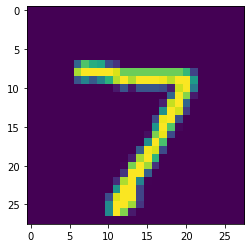

784


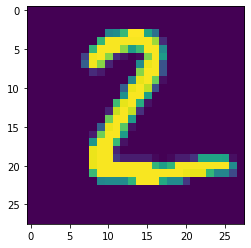

In [5]:
plt.imshow(mnistdata.dataset.data[0,:,:])
input_0 = mnistdata.dataset.data[0,:,:].reshape(mnistdata.dataset.data.shape[1]*mnistdata.dataset.data.shape[2])
print(len(input_0))
plt.show()

plt.imshow(mnistdata.dataset.data[1,:,:])
input_1 = mnistdata.dataset.data[1,:,:].reshape(mnistdata.dataset.data.shape[1]*mnistdata.dataset.data.shape[2])
print(len(input_1))
plt.show()

3. Now, let us emulate the impact of the Balun (10 MHz - 8 GHz)

In [6]:
from scipy.fft import fft, ifft, fftfreq


def PrintVectorStream(vector, vector2):
    print("vector.shape:", vector.shape)
    print("Max:", max(vector))
    print("Min:", min(vector))
    
    plt.figure()
    plt.plot(vector, ".", label="Initial voltages")
    plt.plot(vector2, ".", label="Filtered voltages")
    plt.xlabel("Index of vector")
    plt.ylabel("weigth values")
    plt.title("Vector shape")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    diff_vector = [vector[i] - vector2[i] for i in range(len(vector2))]
    plt.figure()
    plt.plot(diff_vector, ".")
    plt.xlabel("Index of vector")
    plt.ylabel("weigth values difference")
    plt.title("Vector difference")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


def BalunFilter(vector, gsps, min_freq=0.01, max_freq=8):
    vector[:] = [x/max(max(vector), abs(min(vector))) for x in vector]
    n = int(len(vector))
    frequency = fftfreq(n, 1/gsps)
    fft_vector = fft(vector)

    # initial signal spectrum
    plt.figure()
    plt.stem(frequency, abs(fft_vector)/len(vector), linefmt="C0-", markerfmt="C0.", basefmt=None, label="Initial")
    
    # apply balun filter
    for j in range(len(frequency)):
        if abs(frequency[j]) <= min_freq or abs(frequency[j]) >= max_freq:
            fft_vector[j] = 0
    
    plt.stem(frequency, abs(fft_vector)/len(vector), linefmt="C1-", markerfmt="C1.", basefmt=None, label="Filtered")
    plt.title("Signal spectrum")
    plt.xlabel('Freq (GHz)')
    plt.ylabel('|Y(freq)|')
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    # reconstruct the signal
    reconstruct_vector = ifft(fft_vector)
    
    return reconstruct_vector


Here, we modify the bias voltage to the average of the data stream, then we reduce the DC to its minimal.

Layer 1 of LeNet


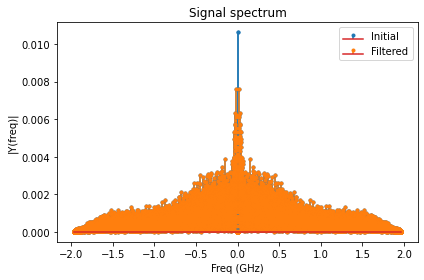

vector.shape: (25360,)
Max: 1.0
Min: -0.18945463018931205


/home/zhizhenz/anaconda3/envs/torch/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


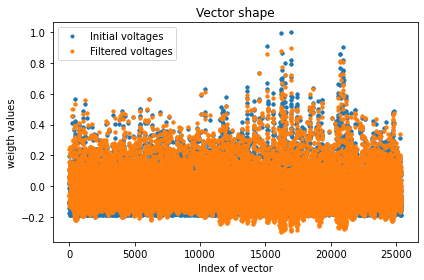

No handles with labels found to put in legend.


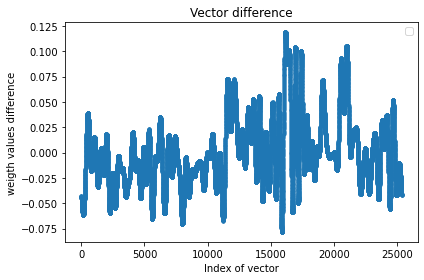

Layer 2 of LeNet


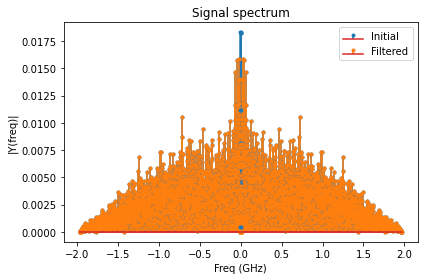

vector.shape: (3232,)
Max: 1.0
Min: -0.2566652152710563


/home/zhizhenz/anaconda3/envs/torch/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


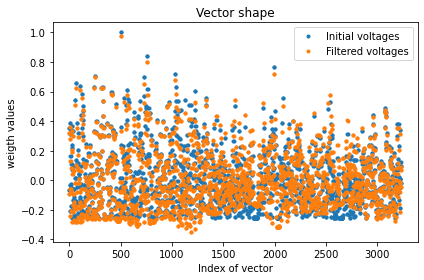

No handles with labels found to put in legend.


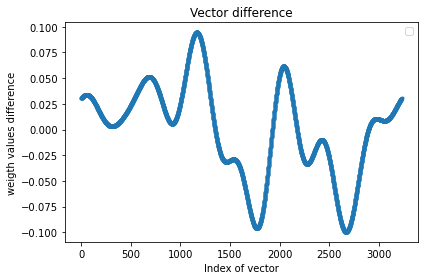

Layer 3 of LeNet


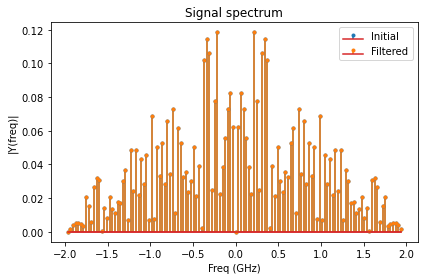

vector.shape: (128,)
Max: 0.9738032864967848
Min: -1.0


/home/zhizhenz/anaconda3/envs/torch/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


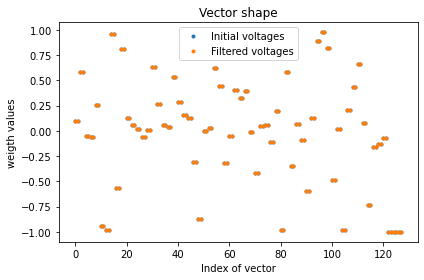

No handles with labels found to put in legend.


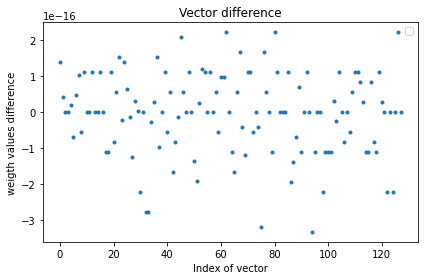

In [9]:
print("Layer 1 of LeNet")
lenet_weight_stream_1_mean = sum(lenet_weight_stream_1)/len(lenet_weight_stream_1)
vector1 = [(x-lenet_weight_stream_1_mean)/max(max(lenet_weight_stream_1), abs(min(lenet_weight_stream_1))) for x in lenet_weight_stream_1]
filter_lenet_weight_stream_1 = BalunFilter(vector1, 3.93216)
PrintVectorStream(np.array(vector1), np.array(filter_lenet_weight_stream_1))

print("Layer 2 of LeNet")
lenet_weight_stream_2_mean = sum(lenet_weight_stream_2)/len(lenet_weight_stream_2)
vector2 = [(x-lenet_weight_stream_2_mean)/max(max(lenet_weight_stream_2), abs(min(lenet_weight_stream_2))) for x in lenet_weight_stream_2]
filter_lenet_weight_stream_2 = BalunFilter(vector2, 3.93216)
PrintVectorStream(np.array(vector2), np.array(filter_lenet_weight_stream_2))

print("Layer 3 of LeNet")
lenet_weight_stream_3_mean = sum(lenet_weight_stream_3)/len(lenet_weight_stream_3)
vector3 = [(x-lenet_weight_stream_3_mean)/max(max(lenet_weight_stream_3), abs(min(lenet_weight_stream_3))) for x in lenet_weight_stream_3]
filter_lenet_weight_stream_3 = BalunFilter(vector3, 3.93216)
PrintVectorStream(np.array(vector3), np.array(filter_lenet_weight_stream_3))

4. Now let us see how the Balun is affecting the input data. Here we assume we load the entire image into the memory to calculate its mean value for DC supression. In other scenarios like large picture or video understanding, we may not be able to get entire data for mean value so that a time frame scheme may be needed.

784


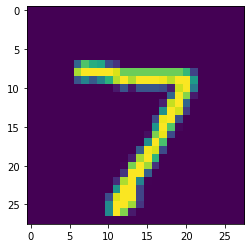

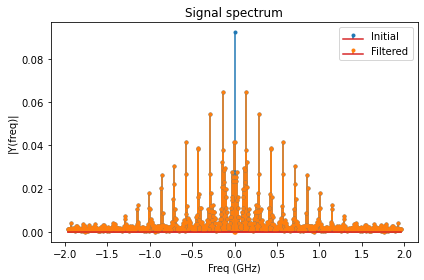

vector.shape: (784,)
Max: 1.0
Min: -0.00011005612


/home/zhizhenz/anaconda3/envs/torch/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


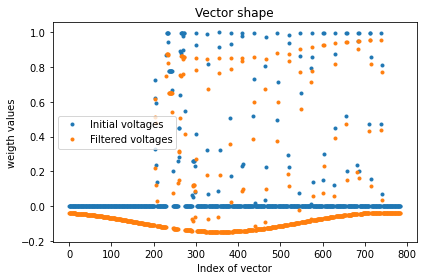

No handles with labels found to put in legend.


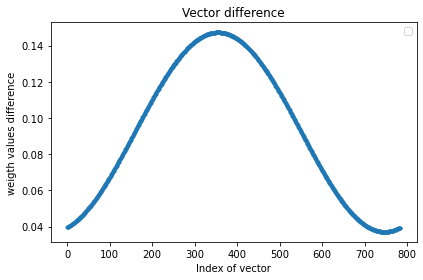

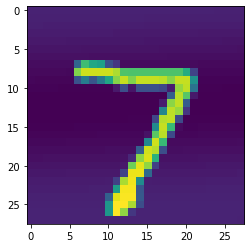

In [20]:
image_0 = mnistdata.dataset.data[0,:,:]
input_0 = image_0.reshape(image_0.shape[0]*image_0.shape[1])
print(len(input_0))
plt.figure()
plt.imshow(image_0)
plt.show()

input_0_mean = sum(input_0)/len(input_0)
vector_0 = [(x-input_0_mean)/max(max(input_0), abs(min(input_0))) for x in input_0]
filter_vector_0 = BalunFilter(vector_0, 3.93216)
PrintVectorStream(np.array(vector_0), np.array(filter_vector_0))

filter_image_0 = filter_vector_0.reshape((image_0.shape[0], image_0.shape[1]))
plt.figure()
plt.imshow(np.real(filter_image_0))
plt.show()